In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [2]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((54315, 59), (9586, 59), (54315, 1), (9586, 1))

In [3]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
 'Empleado',
 'Tiempo_empleo',
 'Saldo_cuenta',
 'Valor_prestamo',
 'Cuentas_otros',
 'Autocontrol',
 'Impulsividad',
 'Confianza' 
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.48037,-0.00128,-0.00633,-0.00115,0.00754,-0.00448,0.00228,-0.00068
Tiempo_empleo,0.48037,1.00000,0.00696,-0.00080,-0.00228,0.00410,-0.00682,0.00556,0.00129
Saldo_cuenta,-0.00128,0.00696,1.00000,0.00120,0.00043,-0.00272,0.00377,-0.00196,-0.00716
Valor_prestamo,-0.00633,-0.00080,0.00120,1.00000,-0.00041,0.00983,-0.00334,-0.00069,-0.00088
Cuentas_otros,-0.00115,-0.00228,0.00043,-0.00041,1.00000,-0.00159,0.00314,-0.00146,0.00477
Autocontrol,0.00754,0.00410,-0.00272,0.00983,-0.00159,1.00000,0.00585,0.00627,-0.00449
Impulsividad,-0.00448,-0.00682,0.00377,-0.00334,0.00314,0.00585,1.00000,-0.00233,-0.00322
Confianza,0.00228,0.00556,-0.00196,-0.00069,-0.00146,0.00627,-0.00233,1.00000,-0.00062
target,-0.00068,0.00129,-0.00716,-0.00088,0.00477,-0.00449,-0.00322,-0.00062,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00716
Cuentas_otros,0.00477
Autocontrol,0.00449
Impulsividad,0.00322
Tiempo_empleo,0.00129
Valor_prestamo,0.00088
Empleado,0.00068
Confianza,0.00062


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.61396,0.00270,-0.00463,0.00038,0.00647,-0.00503,0.00187,-0.00068
Tiempo_empleo,0.61396,1.00000,0.00137,-0.00128,-0.00269,0.00448,-0.00591,0.00414,0.00045
Saldo_cuenta,0.00270,0.00137,1.00000,0.00463,0.00004,-0.00199,0.00101,-0.00535,-0.00680
Valor_prestamo,-0.00463,-0.00128,0.00463,1.00000,-0.00142,0.00946,-0.00336,-0.00009,-0.00345
Cuentas_otros,0.00038,-0.00269,0.00004,-0.00142,1.00000,-0.00163,0.00415,-0.00101,0.00393
Autocontrol,0.00647,0.00448,-0.00199,0.00946,-0.00163,1.00000,0.00551,0.00627,-0.00370
Impulsividad,-0.00503,-0.00591,0.00101,-0.00336,0.00415,0.00551,1.00000,-0.00156,-0.00377
Confianza,0.00187,0.00414,-0.00535,-0.00009,-0.00101,0.00627,-0.00156,1.00000,-0.00111
target,-0.00068,0.00045,-0.00680,-0.00345,0.00393,-0.00370,-0.00377,-0.00111,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00680
Cuentas_otros,0.00393
Impulsividad,0.00377
Autocontrol,0.00370
Valor_prestamo,0.00345
Confianza,0.00111
Empleado,0.00068
Tiempo_empleo,0.00045


In [9]:
del x_train['target']

In [10]:
import statsmodels.api as sm

logit_model_2 = sm.Logit(y_train , x_train[cols_aporte])
result_2 = logit_model_2.fit()

Optimization terminated successfully.
         Current function value: 0.409889
         Iterations 6


In [33]:
#help(logit_model_2.fit)

In [34]:
pesos_ = pd.DataFrame(calcular_pesos(result_2)).reset_index()
pesos_

,index,pesos
0,Tiempo_empleo,0.047774
1,Cuentas_otros,0.309007
2,Saldo_cuenta,0.993621
3,Empleado,5.879682
4,Valor_prestamo,7.954889
5,Impulsividad,24.826648
6,Confianza,28.326063
7,Autocontrol,31.662316


In [35]:
pesos_.to_excel('pesos_originales.xlsx', index=False)

In [36]:
result_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: -0.007    
Dependent Variable: Incumplimiento   AIC:              44542.2532
Date:               2021-06-05 19:08 BIC:              44613.4737
No. Observations:   54315            Log-Likelihood:   -22263.   
Df Model:           7                LL-Null:          -22109.   
Df Residuals:       54307            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Empleado         -0.1902   0.0367  -5.1830 0.0000 -0.2621 -0.1183
Tiempo_empleo     0.0708   0.1515   0.4672 0.6404 -0.2262  0.3678
Saldo_cuenta     -3.4593   1.6236  -2.1306 0.0331 -6.6415 -0.2771
Valor_prestamo   -0.3602   0.0597  -6.0286 0.0000 -0.4773 -0.2431
Cuentas_otros    -0.1014   0.0853  -1.1882 0.2348 -0.2686  0.0658
Autocontrol      -1.0642   0.0885 -12.0274 0.0000 -1.2377 -0.8908
Impulsividad     -0.9125   0.0857 -10.6502 0.0000 -1.0804 -0.7445
Confianza        -1.0141   0.0891 -11.3761 0.0000 -1.1888 -0.8394
=================================================================

"""

In [37]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict(x_train[cols_aporte])
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict(x_valid[cols_aporte])
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [38]:
pd.Series(y_pred_class_2_train).value_counts()

0    54315
dtype: int64

In [39]:
pd.Series(y_pred_class_2_valid).value_counts()

0    9586
dtype: int64

<AxesSubplot:>

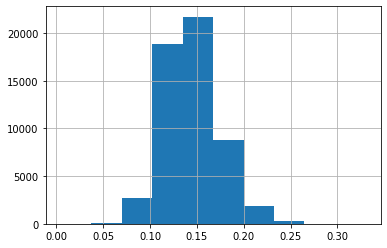

In [40]:
y_pred_prob_2_train.hist()

<AxesSubplot:>

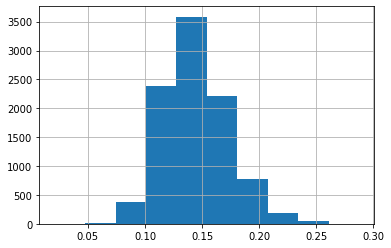

In [41]:
y_pred_prob_2_valid.hist()

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, accuracy_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.505
GINI: 0.011
///////////////////////// VALIDATION
AUC: 0.507
GINI: 0.014


In [43]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### >>> RECALL

In [44]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)]
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 5
 success: True
       x: array([0.05451543])

In [45]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.05451543136062381

In [46]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [47]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    54303
0       12
dtype: int64

In [48]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    9584
0       2
dtype: int64

In [49]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14118925
F1 SCORE   : 0.24744231
///////////////////////// VALIDATION
RECALL     : 1.00000000
EFECTIVIDAD: 0.14117279
F1 SCORE   : 0.24741702


#### >>> EFECTIVIDAD

In [50]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)]
)
optimization_pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     fun: -0.3333333333333333
 message: 'Optimization terminated successfully.'
    nfev: 182
     nit: 11
 success: True
       x: array([0.29153277])

#### >>> AUC

In [51]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)]
)
optimization_auc

     fun: -0.5009503167754273
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.17566663])

In [52]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.17566662842575215

In [53]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [54]:
print("/"*25, "TRAIN")
print("ac     : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_auc))
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("AC     : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_auc))
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
ac     : 0.75975329
RECALL     : 0.14034172
EFECTIVIDAD: 0.14281922
F1 SCORE   : 0.14156963
///////////////////////// VALIDATION
AC     : 0.75975329
RECALL     : 0.13821138
EFECTIVIDAD: 0.14263921
F1 SCORE   : 0.14039039
